In [233]:
# !pip install lifetimes
# !pip install sqlalchemy

In [234]:
from sqlalchemy import create_engine
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import summary_data_from_transaction_data
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

pd.options.display.max_columns = None  # 길어서 생략된 열 다 보이게 하기

In [235]:
from sklearn.metrics import silhouette_score

In [236]:
products = pd.read_parquet("/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/products_optimized.parquet")
products

,product_id,cost,category,product_name,brand,retail_price,department,sku,distribution_center_id
0,13842,2.51875,Accessories,Low Profile Dyed Cotton Twill Cap - Navy W39S55D,MG,6.25,Women,EBD58B8A3F1D72F4206201DA62FB1204,1
1,13928,2.33835,Accessories,Low Profile Dyed Cotton Twill Cap - Putty W39S55D,MG,5.95,Women,2EAC42424D12436BDD6A5B8A88480CC3,1
2,14115,4.87956,Accessories,Enzyme Regular Solid Army Caps-Black W35S45D,MG,10.99,Women,EE364229B2791D1EF9355708EFF0BA34,1
3,14157,4.64877,Accessories,Enzyme Regular Solid Army Caps-Olive W35S45D (...,MG,10.99,Women,00BD13095D06C20B11A2993CA419D16B,1
4,14273,6.50793,Accessories,Washed Canvas Ivy Cap - Black W11S64C,MG,15.99,Women,F531DC20FDE20B7ADF3A73F52B71D0AF,1
...,...,...,...,...,...,...,...,...,...
29115,5676,12.42338,Pants & Capris,WHAT GOES AROUND COMES AROUND Women's Colette ...,What Goes Around Comes Around,24.17,Women,3A01FC0853EBEBA94FDE4D1CC6FB842A,10
29116,6538,13.67500,Shorts,WHAT GOES AROUND COMES AROUND Women's Mimi Shorts,What Goes Around Comes Around,25.00,Women,741A0099C9AC04C7BFC822CAF7C7459F,10
29117,6712,12.40000,Shorts,WHAT GOES AROUND COMES AROUND Women's Fifi Short,What Goes Around Comes Around,25.00,Women,5726DAF2C9EE0F955ECA58291C26D2F3,10
29118,6821,13.47500,Shorts,WHAT GOES AROUND COMES AROUND Women's Ferguson...,What Goes Around Comes Around,25.00,Women,BA0A4D6ECEA3E9E126DD3B6D77291C97,10


In [237]:
order_items = pd.read_parquet('/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/order_items_optimized.parquet')

In [238]:
# 구매건만 남기기
order_items_extracted = order_items.query('status != "Returned" and status != "Cancelled"')


In [239]:
# 'created_at' 열을 datetime 형식으로 변환
order_items_extracted['created_at'] = pd.to_datetime(order_items_extracted['created_at'])

# UTC에서 로컬 시간으로 변환
order_items_extracted['created_at'] = order_items_extracted['created_at'].dt.tz_localize(None)

# 'created_at' 열의 데이터 타입 확인
print(order_items_extracted['created_at'].dtype)

# "2023-12-01" 이전의 행만 선택
order_items_extracted = order_items_extracted.query('created_at < "2023-12-01"')

datetime64[ns]


In [240]:
# Recency 계산 (데이터 제일 최근 날짜 + 1일 기준)
recency = order_items_extracted .groupby('user_id')['created_at'].max().reset_index()
recency['recency'] = (order_items_extracted['created_at'].max()+ pd.to_timedelta(1, unit='d') - recency['created_at']).dt.days

In [241]:
# Frequency 계산
frequency = order_items_extracted.groupby('user_id')['order_id'].nunique().reset_index()

In [242]:
# Monetary 계산
monetary = order_items_extracted.groupby('user_id')['sale_price'].sum().reset_index()

In [243]:
# RFM 데이터프레임 생성
rfm = pd.merge(recency[['user_id', 'recency']], frequency, on='user_id')
rfm = pd.merge(rfm, monetary, on='user_id')
rfm = rfm.rename(columns={'order_id' : 'frequency'})
rfm= rfm.rename(columns={'sale_price' : 'monetary'})
rfm["monetary"] = rfm["monetary"] / rfm["frequency"]
rfm


,user_id,recency,frequency,monetary
0,1,499,1,159.990000
1,2,649,1,22.000000
2,3,115,4,100.550000
3,4,409,1,148.000000
4,6,599,1,144.820004
...,...,...,...,...
58459,99989,91,1,15.120000
58460,99992,479,1,55.950001
58461,99996,261,2,61.935000
58462,99998,132,3,38.996667


In [244]:
from sklearn.cluster import KMeans

In [295]:
# 모델 초기화
kmeans = KMeans(n_clusters=3, random_state=42)

# RFM 데이터를 사용하여 모델 학습
rfm_data = rfm[['user_id','recency', 'frequency', 'monetary']]
kmeans.fit(rfm_data[['recency', 'frequency', 'monetary']])

# 클러스터링 결과 확인
rfm_data['cluster'] = kmeans.labels_

# 결과 출력
print(rfm_data)

       user_id  recency  frequency    monetary  cluster
0            1      499          1  159.990000        2
1            2      649          1   22.000000        2
2            3      115          4  100.550000        0
3            4      409          1  148.000000        2
4            6      599          1  144.820004        2
...        ...      ...        ...         ...      ...
58459    99989       91          1   15.120000        0
58460    99992      479          1   55.950001        2
58461    99996      261          2   61.935000        0
58462    99998      132          3   38.996667        0
58463   100000     1190          1  129.949997        1

[58464 rows x 5 columns]


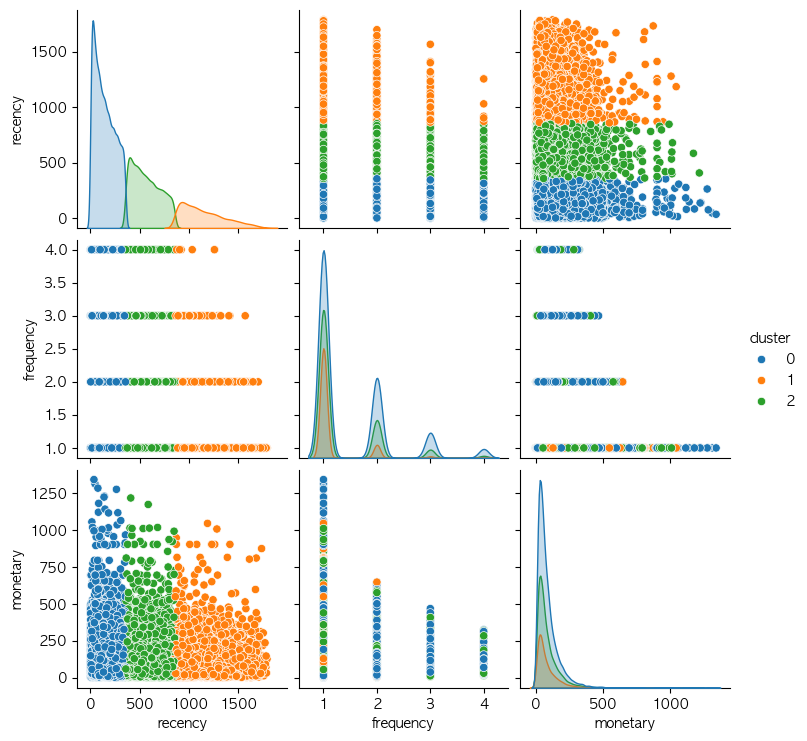

In [296]:
features = ['recency', 'frequency', 'monetary']

# 클러스터링 결과를 hue로 지정하여 시각화
sns.pairplot(rfm_data, vars=features, hue='cluster', palette='tab10', diag_kind='kde')

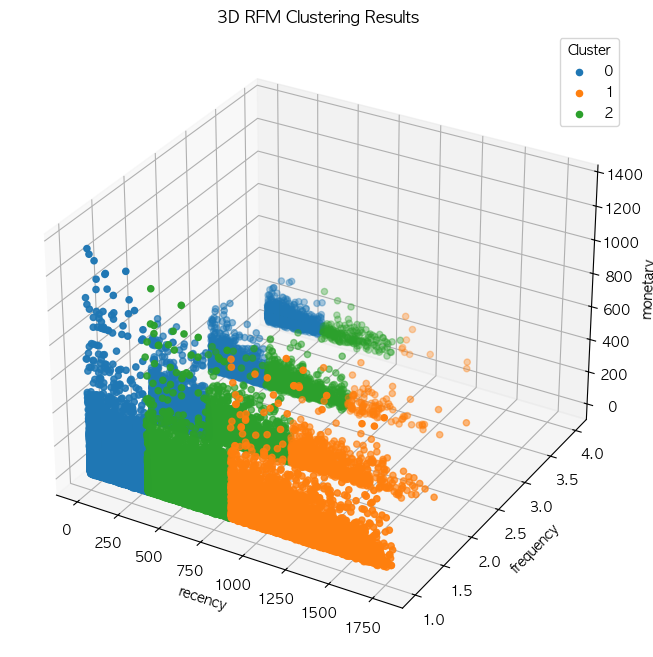

In [297]:
x_feature = 'recency'
y_feature = 'frequency'
z_feature = 'monetary'

# 클러스터링 결과를 색상으로 구분하여 3D 산점도 그리기
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label, cluster in rfm_data.groupby('cluster'):
    ax.scatter(cluster[x_feature], cluster[y_feature], cluster[z_feature], label=label)

ax.set_xlabel(x_feature)
ax.set_ylabel(y_feature)
ax.set_zlabel(z_feature)
ax.set_title('3D RFM Clustering Results')
ax.legend(title='Cluster')

In [248]:
#from sklearn.metrics import silhouette_score

# 실루엣 점수 계산
#silhouette_avg = silhouette_score(rfm_data, rfm_data['cluster'])

# 실루엣 점수 출력
#print(f'Silhouette Score: {silhouette_avg}')

In [298]:
print(rfm_data.columns)

Index(['user_id', 'recency', 'frequency', 'monetary', 'cluster'], dtype='object')


In [299]:
import numpy as np

# GKSMS QJQ 방법론을 이용하여 각 고객의 CLV 계산
rfm_data['G'] = rfm_data['monetary']  # 과거 고객 가치 (Monetary를 사용)
rfm_data['K'] = rfm_data['monetary'] * rfm_data['frequency']  # 현재 고객 가치
rfm_data['S'] = rfm_data['monetary'] * rfm_data['frequency'] / rfm_data['recency']  # 잔존 고객 가치
rfm_data['M'] = np.log(rfm_data['frequency']) * rfm_data['monetary']  # 모멘텀 고객 가치
#rfm_data['S'] = rfm_data['monetary'] * rfm_data['frequency'] / rfm_data['recency_scaled']  # 소셜 고객 가치
rfm_data['Q'] = rfm_data['monetary'] / rfm_data['frequency']  # 품질 고객 가치
# rfm_data['J'] = rfm_data['monetary'] * np.log(rfm_data['recency_scaled'] )  # 행동 고객 가치
rfm_data['J'] = rfm_data['monetary'] * (1/rfm_data['recency'])

In [300]:
rfm_data['CLV'] = rfm_data[['G', 'K', 'S', 'M', 'Q', 'J']].sum(axis=1)
rfm_data

,user_id,recency,frequency,monetary,cluster,G,K,S,M,Q,J,CLV
0,1,499,1,159.990000,2,159.990000,159.990000,0.320621,0.000000,159.990000,0.320621,480.611242
1,2,649,1,22.000000,2,22.000000,22.000000,0.033898,0.000000,22.000000,0.033898,66.067797
2,3,115,4,100.550000,0,100.550000,402.200001,3.497391,139.391898,25.137500,0.874348,671.651138
3,4,409,1,148.000000,2,148.000000,148.000000,0.361858,0.000000,148.000000,0.361858,444.723716
4,6,599,1,144.820004,2,144.820004,144.820004,0.241770,0.000000,144.820004,0.241770,434.943550
...,...,...,...,...,...,...,...,...,...,...,...,...
58459,99989,91,1,15.120000,0,15.120000,15.120000,0.166154,0.000000,15.120000,0.166154,45.692308
58460,99992,479,1,55.950001,2,55.950001,55.950001,0.116806,0.000000,55.950001,0.116806,168.083614
58461,99996,261,2,61.935000,0,61.935000,123.870001,0.474598,42.930071,30.967500,0.237299,260.414469
58462,99998,132,3,38.996667,0,38.996667,116.990000,0.886288,42.842217,12.998889,0.295429,213.009490


(array([41630.,     0.,     0., 12361.,     0.,     0.,  3386.,     0.,
            0.,  1087.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

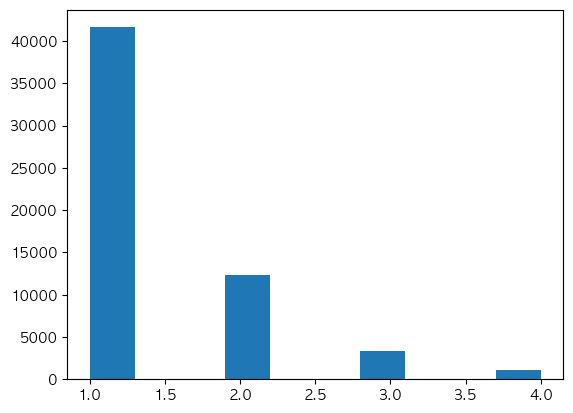

In [301]:
plt.hist(rfm_data['frequency'])

In [302]:
# Selecting relevant columns for clustering
X = rfm_data[['G', 'K', 'S', 'M', 'Q', 'J']]

# Number of clusters you want
num_clusters = 5  # You can adjust this based on your data and requirements

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Adding cluster labels to the DataFrame
rfm_data['cluster'] = kmeans.labels_

# Viewing the clusters
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=['G', 'K', 'S', 'M', 'Q', 'J'])
print(cluster_centers)

# Checking the count of data points in each cluster
print(rfm_data['cluster'].value_counts())

            G           K          S             M           Q         J
0  105.928626  147.646277   2.972093  2.650354e+01   87.803528  1.910213
1  608.773079  755.258681  11.612912  9.252135e+01  545.726899  9.335825
2  258.660171  258.660171   3.405313  1.101341e-13  258.660171  3.405313
3  156.557001  388.959023  10.164957  1.372250e+02   67.084225  3.877185
4   38.415540   45.765450   0.813900  4.853559e+00   35.016985  0.641218
cluster
4    33200
0    16564
2     4225
3     4020
1      455
Name: count, dtype: int64


In [303]:
rfm_data

,user_id,recency,frequency,monetary,cluster,G,K,S,M,Q,J,CLV
0,1,499,1,159.990000,0,159.990000,159.990000,0.320621,0.000000,159.990000,0.320621,480.611242
1,2,649,1,22.000000,4,22.000000,22.000000,0.033898,0.000000,22.000000,0.033898,66.067797
2,3,115,4,100.550000,3,100.550000,402.200001,3.497391,139.391898,25.137500,0.874348,671.651138
3,4,409,1,148.000000,0,148.000000,148.000000,0.361858,0.000000,148.000000,0.361858,444.723716
4,6,599,1,144.820004,0,144.820004,144.820004,0.241770,0.000000,144.820004,0.241770,434.943550
...,...,...,...,...,...,...,...,...,...,...,...,...
58459,99989,91,1,15.120000,4,15.120000,15.120000,0.166154,0.000000,15.120000,0.166154,45.692308
58460,99992,479,1,55.950001,4,55.950001,55.950001,0.116806,0.000000,55.950001,0.116806,168.083614
58461,99996,261,2,61.935000,0,61.935000,123.870001,0.474598,42.930071,30.967500,0.237299,260.414469
58462,99998,132,3,38.996667,4,38.996667,116.990000,0.886288,42.842217,12.998889,0.295429,213.009490


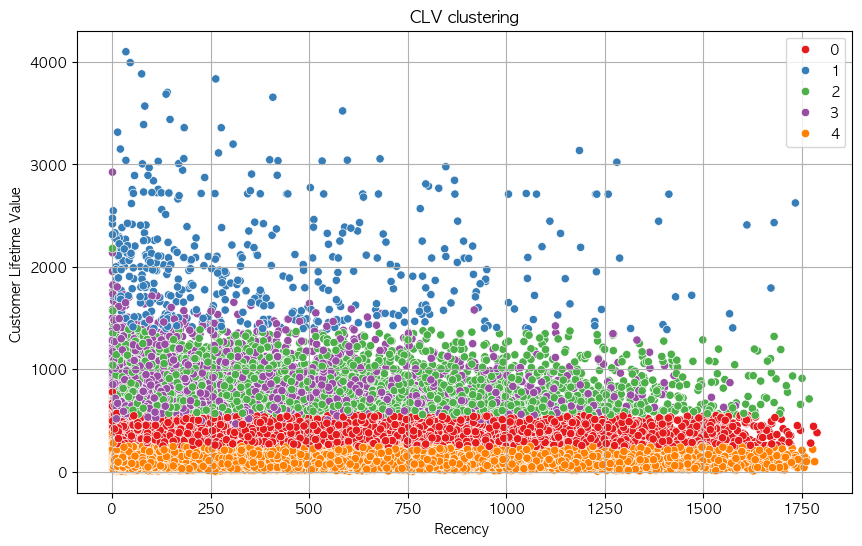

In [304]:
# 산점도 그리기
plt.figure(figsize=(10, 6))

# 각 클러스터에 대한 산점도
sns.scatterplot(x='recency', y='CLV', hue='cluster', data=rfm_data, palette='Set1')


# 라벨과 제목 추가
plt.xlabel('Recency ')
plt.ylabel('Customer Lifetime Value ')
plt.title('CLV clustering')
plt.legend()
plt.grid(True)
plt.show()

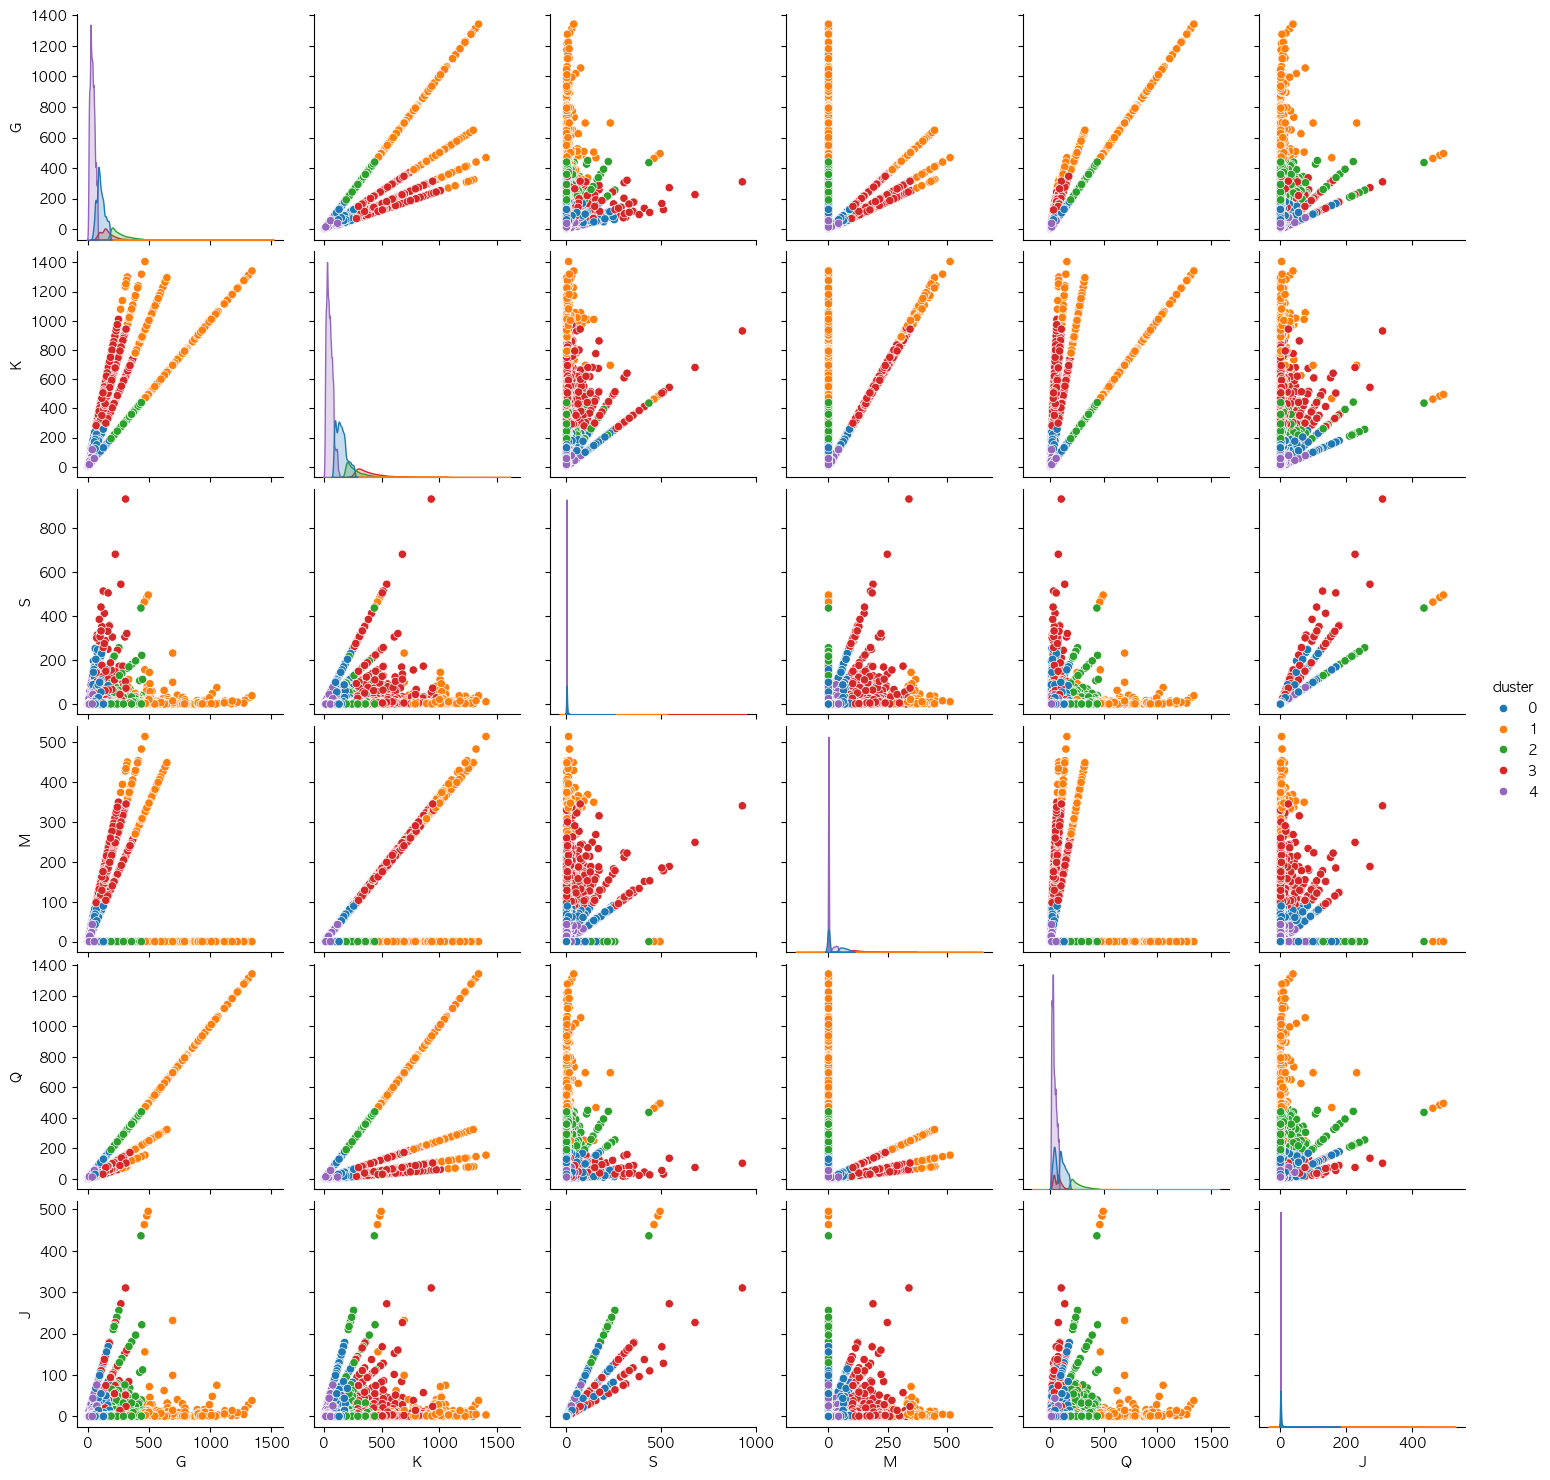

In [305]:
features = ['G', 'K', 'S', 'M', 'Q', 'J']
# 클러스터링 결과를 hue로 지정하여 시각화
sns.pairplot(rfm_data, vars=features, hue='cluster', palette='tab10', diag_kind='kde')

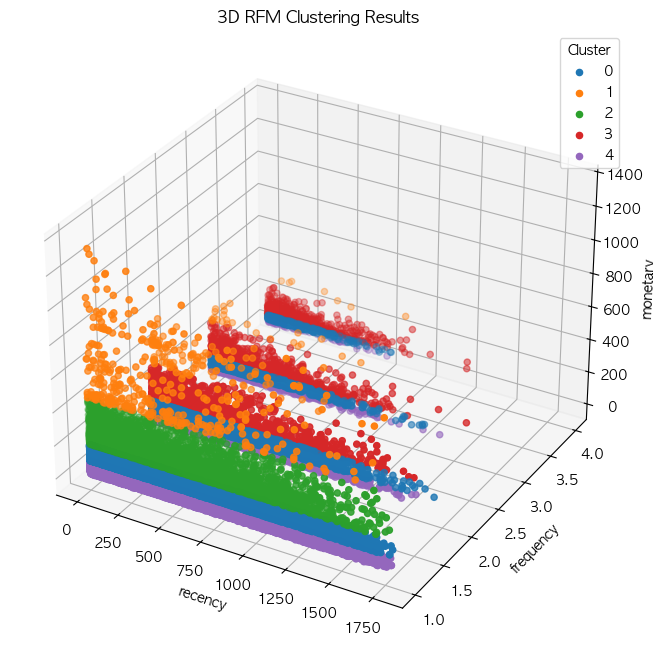

In [306]:
x_feature = 'recency'
y_feature = 'frequency'
z_feature = 'monetary'

# 클러스터링 결과를 색상으로 구분하여 3D 산점도 그리기
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label, cluster in rfm_data.groupby('cluster'):
    ax.scatter(cluster[x_feature], cluster[y_feature], cluster[z_feature], label=label)

ax.set_xlabel(x_feature)
ax.set_ylabel(y_feature)
ax.set_zlabel(z_feature)
ax.set_title('3D RFM Clustering Results')
ax.legend(title='Cluster')

In [307]:
rfm_data.groupby('cluster').agg({
    'recency' : ['mean', 'min', 'max'],
    'frequency' : ['mean', 'min', 'max'],
    'monetary' : ['mean', 'min', 'max'],
    'CLV' : ['mean', 'min', 'max', 'count']
})

recency           frequency            monetary              \
               mean min   max      mean min max        mean         min   
cluster                                                                   
0        396.677131   1  1789  1.542743   1   4  105.924322   35.422501   
1        412.769231   1  1734  1.349451   1   4  608.773079  269.847500   
2        453.433136   1  1769  1.000000   1   1  258.660171  183.290001   
3        280.493532   1  1582  2.632836   2   4  156.557001   67.730000   
4        433.931566   1  1783  1.201235   1   4   38.413620    0.020000   

                              CLV                                   
                 max         mean          min          max  count  
cluster                                                             
0         183.129999   372.752258   235.321851   892.199993  16564  
1        1341.489998  2023.228742  1388.126963  4101.126565    455  
2         461.140000   782.791138   551.221050  2179.749947   4225  
3         372.495001   763.867380   453.443694  2925.255056   4020  
4          82.389999   125.497753     0.060153   412.491034  33200

In [258]:
rfm_data

,user_id,recency,frequency,monetary,cluster,G,K,S,M,Q,J,CLV
0,1,499,1,159.990000,0,159.990000,159.990000,0.320621,0.000000,159.990000,0.320621,480.611242
1,2,649,1,22.000000,4,22.000000,22.000000,0.033898,0.000000,22.000000,0.033898,66.067797
2,3,115,4,100.550000,3,100.550000,402.200001,3.497391,139.391898,25.137500,0.874348,671.651138
3,4,409,1,148.000000,0,148.000000,148.000000,0.361858,0.000000,148.000000,0.361858,444.723716
4,6,599,1,144.820004,0,144.820004,144.820004,0.241770,0.000000,144.820004,0.241770,434.943550
...,...,...,...,...,...,...,...,...,...,...,...,...
58459,99989,91,1,15.120000,4,15.120000,15.120000,0.166154,0.000000,15.120000,0.166154,45.692308
58460,99992,479,1,55.950001,4,55.950001,55.950001,0.116806,0.000000,55.950001,0.116806,168.083614
58461,99996,261,2,61.935000,0,61.935000,123.870001,0.474598,42.930071,30.967500,0.237299,260.414469
58462,99998,132,3,38.996667,4,38.996667,116.990000,0.886288,42.842217,12.998889,0.295429,213.009490


In [259]:
order_items_extracted

,order_item_id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price
1,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaT,0.02
4,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59,2022-06-19 19:29:00+00:00,NaT,NaT,0.02
5,154022,106052,84693,14235,415780,Shipped,2023-09-19 09:13:08,2023-09-16 09:24:00+00:00,NaT,NaT,0.02
6,67253,46269,37023,14159,181497,Complete,2021-10-31 01:26:46,2021-11-01 17:47:00+00:00,2021-11-02 13:29:00+00:00,NaT,0.49
7,116116,80002,63821,14159,313368,Complete,2022-04-01 13:25:52,2022-03-31 05:13:00+00:00,2022-04-02 22:18:00+00:00,NaT,0.49
...,...,...,...,...,...,...,...,...,...,...,...
181753,51581,35450,28392,23546,139190,Processing,2023-10-24 18:42:24,NaT,NaT,NaT,999.00
181755,7801,5416,4283,24447,21078,Shipped,2022-01-12 23:51:07,2022-01-10 03:42:00+00:00,NaT,NaT,999.00
181756,62986,43364,34691,23546,169937,Shipped,2023-02-26 00:38:43,2023-02-25 06:53:00+00:00,NaT,NaT,999.00
181757,106577,73418,58623,24447,287560,Shipped,2023-11-12 02:41:02,2023-11-14 20:44:00+00:00,NaT,NaT,999.00


In [260]:
products

,product_id,cost,category,product_name,brand,retail_price,department,sku,distribution_center_id
0,13842,2.51875,Accessories,Low Profile Dyed Cotton Twill Cap - Navy W39S55D,MG,6.25,Women,EBD58B8A3F1D72F4206201DA62FB1204,1
1,13928,2.33835,Accessories,Low Profile Dyed Cotton Twill Cap - Putty W39S55D,MG,5.95,Women,2EAC42424D12436BDD6A5B8A88480CC3,1
2,14115,4.87956,Accessories,Enzyme Regular Solid Army Caps-Black W35S45D,MG,10.99,Women,EE364229B2791D1EF9355708EFF0BA34,1
3,14157,4.64877,Accessories,Enzyme Regular Solid Army Caps-Olive W35S45D (...,MG,10.99,Women,00BD13095D06C20B11A2993CA419D16B,1
4,14273,6.50793,Accessories,Washed Canvas Ivy Cap - Black W11S64C,MG,15.99,Women,F531DC20FDE20B7ADF3A73F52B71D0AF,1
...,...,...,...,...,...,...,...,...,...
29115,5676,12.42338,Pants & Capris,WHAT GOES AROUND COMES AROUND Women's Colette ...,What Goes Around Comes Around,24.17,Women,3A01FC0853EBEBA94FDE4D1CC6FB842A,10
29116,6538,13.67500,Shorts,WHAT GOES AROUND COMES AROUND Women's Mimi Shorts,What Goes Around Comes Around,25.00,Women,741A0099C9AC04C7BFC822CAF7C7459F,10
29117,6712,12.40000,Shorts,WHAT GOES AROUND COMES AROUND Women's Fifi Short,What Goes Around Comes Around,25.00,Women,5726DAF2C9EE0F955ECA58291C26D2F3,10
29118,6821,13.47500,Shorts,WHAT GOES AROUND COMES AROUND Women's Ferguson...,What Goes Around Comes Around,25.00,Women,BA0A4D6ECEA3E9E126DD3B6D77291C97,10


In [261]:
rfm_merged = rfm_data.merge(order_items_extracted, on ='user_id', how='left').merge(products, on='product_id')
rfm_merged

,user_id,recency,frequency,monetary,cluster,G,K,S,M,Q,J,CLV,order_item_id,order_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,cost,category,product_name,brand,retail_price,department,sku,distribution_center_id
0,1,499,1,159.990000,0,159.990000,159.990000,0.320621,0.000000,159.990000,0.320621,480.611242,1,1,2953,3,Shipped,2022-07-20 10:32:05,2022-07-20 16:42:00+00:00,NaT,NaT,15.000000,6.000000,Active,Tommy Hilfiger Women's 3 Pack Sports Crew,Tommy Hilfiger,15.000000,Women,E2F9247929B404B2FE98BA6F32301E3B,1
1,1,499,1,159.990000,0,159.990000,159.990000,0.320621,0.000000,159.990000,0.320621,480.611242,3,1,7656,9,Shipped,2022-07-19 11:29:28,2022-07-20 16:42:00+00:00,NaT,NaT,19.990000,8.375810,Blazers & Jackets,Plus size Button Closure Cropped Bolero Jacket...,eVogues Apparel,19.990000,Women,0DD6049F5FA537D41753BE6D37859430,5
2,1,499,1,159.990000,0,159.990000,159.990000,0.320621,0.000000,159.990000,0.320621,480.611242,2,1,4731,7,Shipped,2022-07-20 11:05:38,2022-07-20 16:42:00+00:00,NaT,NaT,125.000000,66.750000,Jeans,Joe's Jeans Women's Skinny Jeans,Joe's Jeans,125.000000,Women,096FFC299200F51751B08DA6D865AE95,6
3,2,649,1,22.000000,4,22.000000,22.000000,0.033898,0.000000,22.000000,0.033898,66.067797,4,2,25774,11,Complete,2022-02-20 10:28:57,2022-02-22 12:23:00+00:00,2022-02-23 18:29:00+00:00,NaT,22.000000,10.384000,Underwear,Tommy Bahama Tropical Print Boxer Short,Tommy Bahama,22.000000,Men,5F6FC587BA2A036B38AFFBB8C0A42008,4
4,3,115,4,100.550000,3,100.550000,402.200001,3.497391,139.391898,25.137500,0.874348,671.651138,8,6,21364,21,Complete,2023-04-03 07:50:36,2023-04-04 05:53:00+00:00,2023-04-06 03:42:00+00:00,NaT,59.500000,28.798000,Jeans,Marc Ecko Cut & Sew Men's Baked Alaska Bootcut...,Marc Ecko Cut & Sew,59.500000,Men,6B387EBBCB8020CE186644D4A4669C6A,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117034,99996,261,2,61.935000,0,61.935000,123.870001,0.474598,42.930071,30.967500,0.237299,260.414469,181749,125219,27368,490678,Processing,2020-08-01 23:33:20,NaT,NaT,NaT,40.000000,16.520000,Sleep & Lounge,Tommy Hilfiger Solid Black & Red Pajama Pants,Tommy Hilfiger,40.000000,Men,AF83DFE0B00BDCE9C850AE8D3C8A1B99,1
117035,99998,132,3,38.996667,4,38.996667,116.990000,0.886288,42.842217,12.998889,0.295429,213.009490,181755,125223,21923,490694,Processing,2023-07-22 05:16:01,NaT,NaT,NaT,21.990000,10.027440,Pants,Allegra K Men Belt Loop Pleats Slant Pockets C...,Allegra K,21.990000,Men,6D7C8FCB2F7A9E4126A6BE9777C5CA49,9
117036,99998,132,3,38.996667,4,38.996667,116.990000,0.886288,42.842217,12.998889,0.295429,213.009490,181753,125221,19164,490690,Processing,2022-12-16 06:35:21,NaT,NaT,NaT,40.000000,20.760000,Sweaters,Original Penguin Men's Kris Sweater,Original Penguin,40.000000,Men,8F9FE000818954F238235F26CA070247,2
117037,99998,132,3,38.996667,4,38.996667,116.990000,0.886288,42.842217,12.998889,0.295429,213.009490,181754,125222,16938,490692,Processing,2023-01-28 06:25:04,NaT,NaT,NaT,55.000000,28.930000,Tops & Tees,Woolrich Men's Elite Discreet Carry Short Slee...,Woolrich,55.000000,Men,7E53526FC58A32E5452294826783A54B,8


## cluster- category 선호도

In [262]:
rfm_merged.groupby('cluster')['category'].value_counts()

cluster  category                     
0        Jeans                            3223
         Sweaters                         2900
         Fashion Hoodies & Sweatshirts    2817
         Swim                             2672
         Intimates                        2651
                                          ... 
4        Suits & Sport Coats               578
         Skirts                            565
         Jumpsuits & Rompers               259
         Suits                              78
         Clothing Sets                      33
Name: count, Length: 130, dtype: int64

In [263]:
cluster_category_counts = rfm_merged.groupby(['cluster', 'category']).size().reset_index(name='count')
cluster_category_counts

# 각 클러스터에서 가장 많이 구매된 카테고리 선택
most_purchased_categories = cluster_category_counts.groupby('cluster').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)
most_purchased_categories


/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_1558/1225906500.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  most_purchased_categories = cluster_category_counts.groupby('cluster').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)


,cluster,category,count
0,0,Jeans,3223
1,0,Sweaters,2900
2,0,Fashion Hoodies & Sweatshirts,2817
3,0,Swim,2672
4,0,Intimates,2651
5,1,Outerwear & Coats,288
6,1,Jeans,115
7,1,Suits & Sport Coats,93
8,1,Active,88
9,1,Fashion Hoodies & Sweatshirts,72


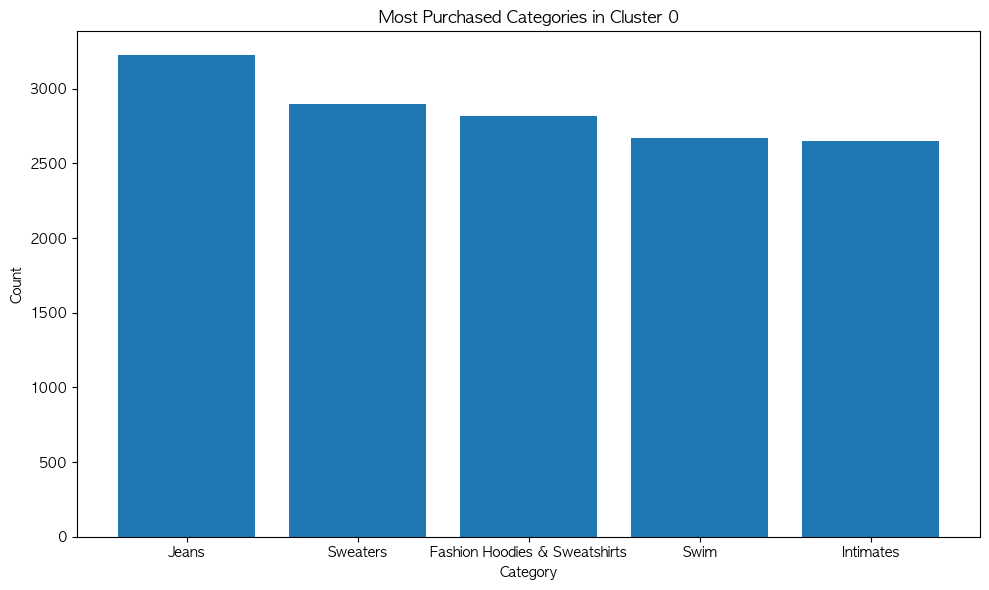

In [264]:
# 클러스터 0에 해당하는 행만 추출
cluster_0_data = most_purchased_categories[most_purchased_categories['cluster'] == 0]

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(cluster_0_data['category'], cluster_0_data['count'])

plt.title('Most Purchased Categories in Cluster 0')
plt.xlabel('Category')
plt.ylabel('Count')

# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


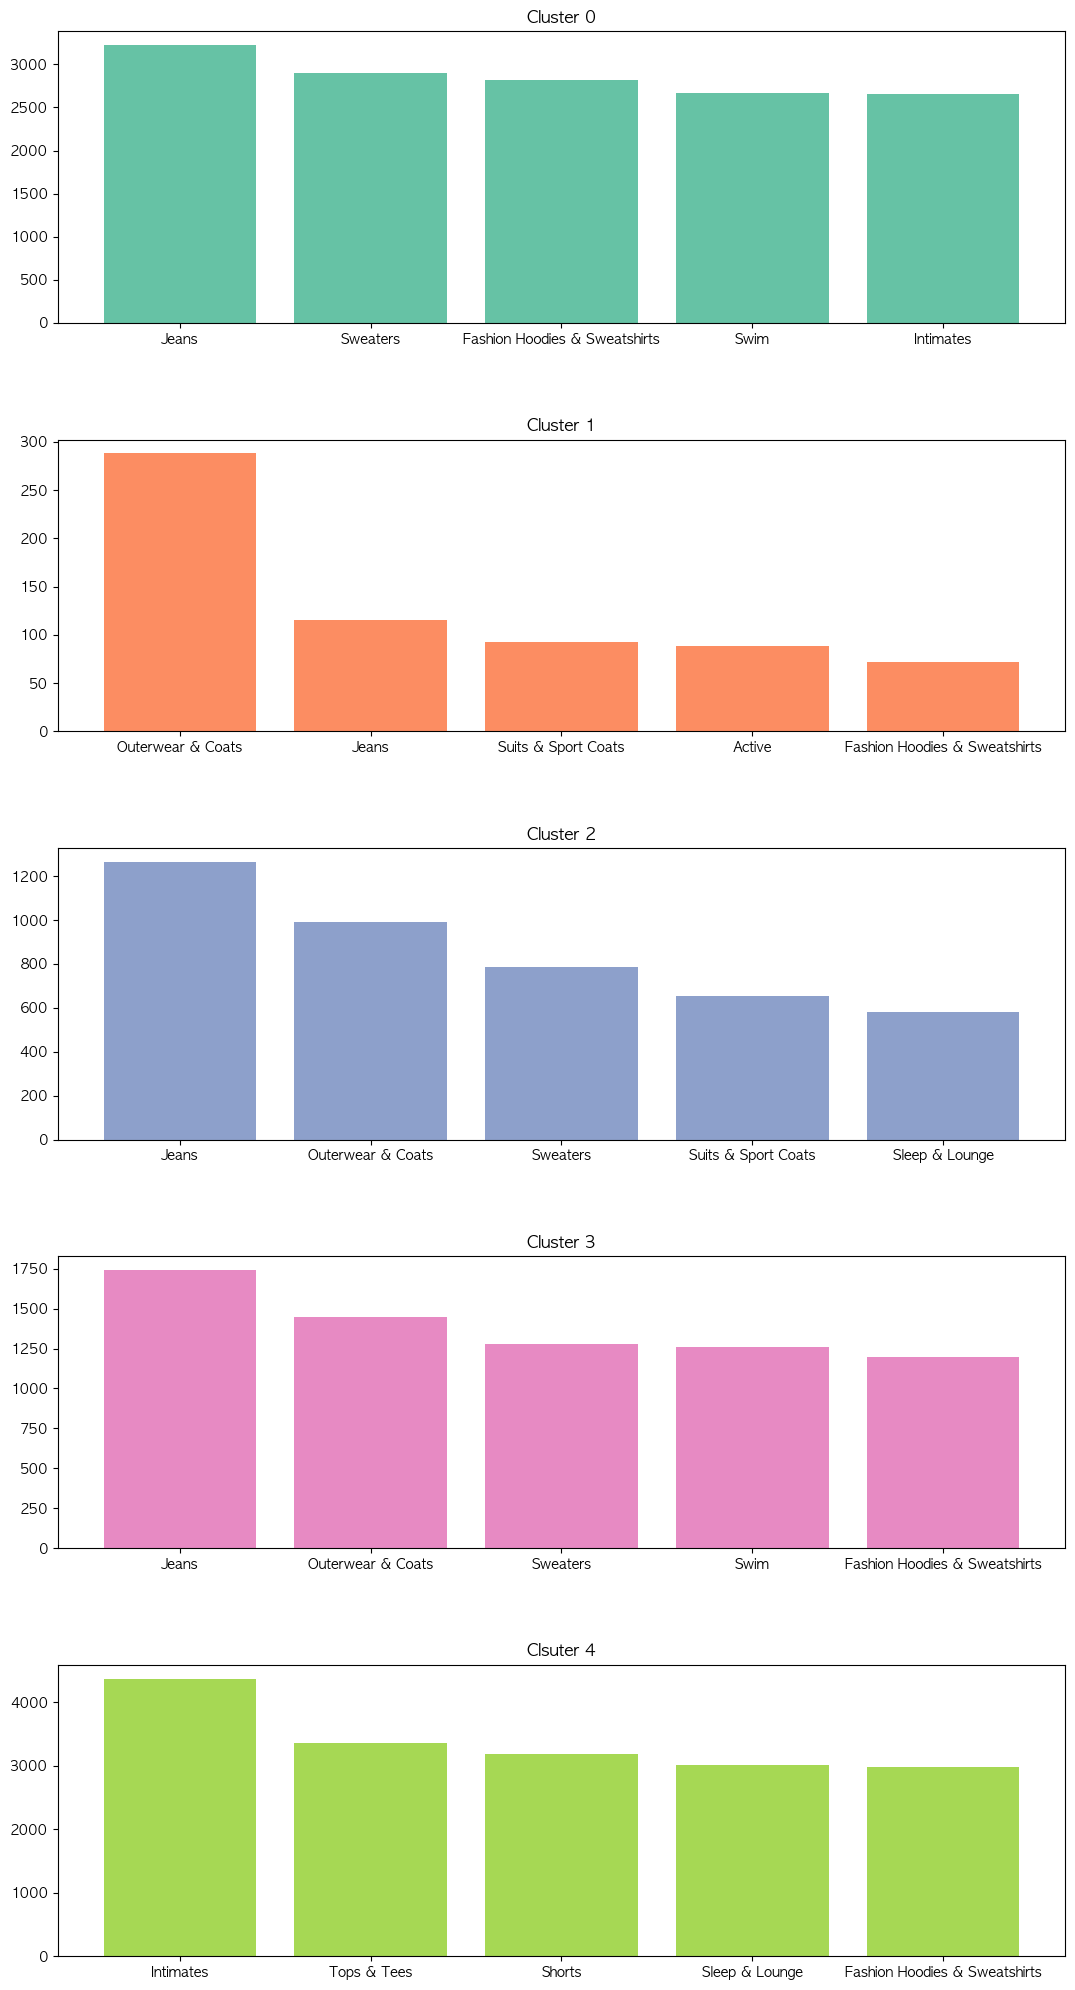

In [265]:
clusters = most_purchased_categories['cluster'].value_counts().index.to_list()

cluster_text = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Clsuter 4']

fig = plt.figure(figsize=(13,25))
fig.subplots_adjust(hspace=0.4)
palette = sns.color_palette("Set2", n_colors=len(clusters))

for i in range(len(clusters)):
    plt.subplot(5,1,i+1)
    data = most_purchased_categories[most_purchased_categories['cluster'] == clusters[i]]
    plt.bar(data['category'], data['count'], color=palette[i])
    plt.title(f"{cluster_text[i]}")
plt.show()


## cluster - brand 선호도 

In [266]:
cluster_brand_counts = rfm_merged.groupby(['cluster', 'brand']).size().reset_index(name='count')
cluster_brand_counts

# 각 클러스터에서 가장 많이 구매된 카테고리 선택
most_purchased_brands = cluster_brand_counts.groupby('cluster').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)
most_purchased_brands

/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_1558/1113576717.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  most_purchased_brands = cluster_brand_counts.groupby('cluster').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)


,cluster,brand,count
0,0,Allegra K,1060
1,0,Calvin Klein,813
2,0,Carhartt,665
3,0,Volcom,405
4,0,Nautica,393
5,1,The North Face,59
6,1,Canada Goose,51
7,1,Arc'teryx,28
8,1,Diesel,26
9,1,Nobis,21


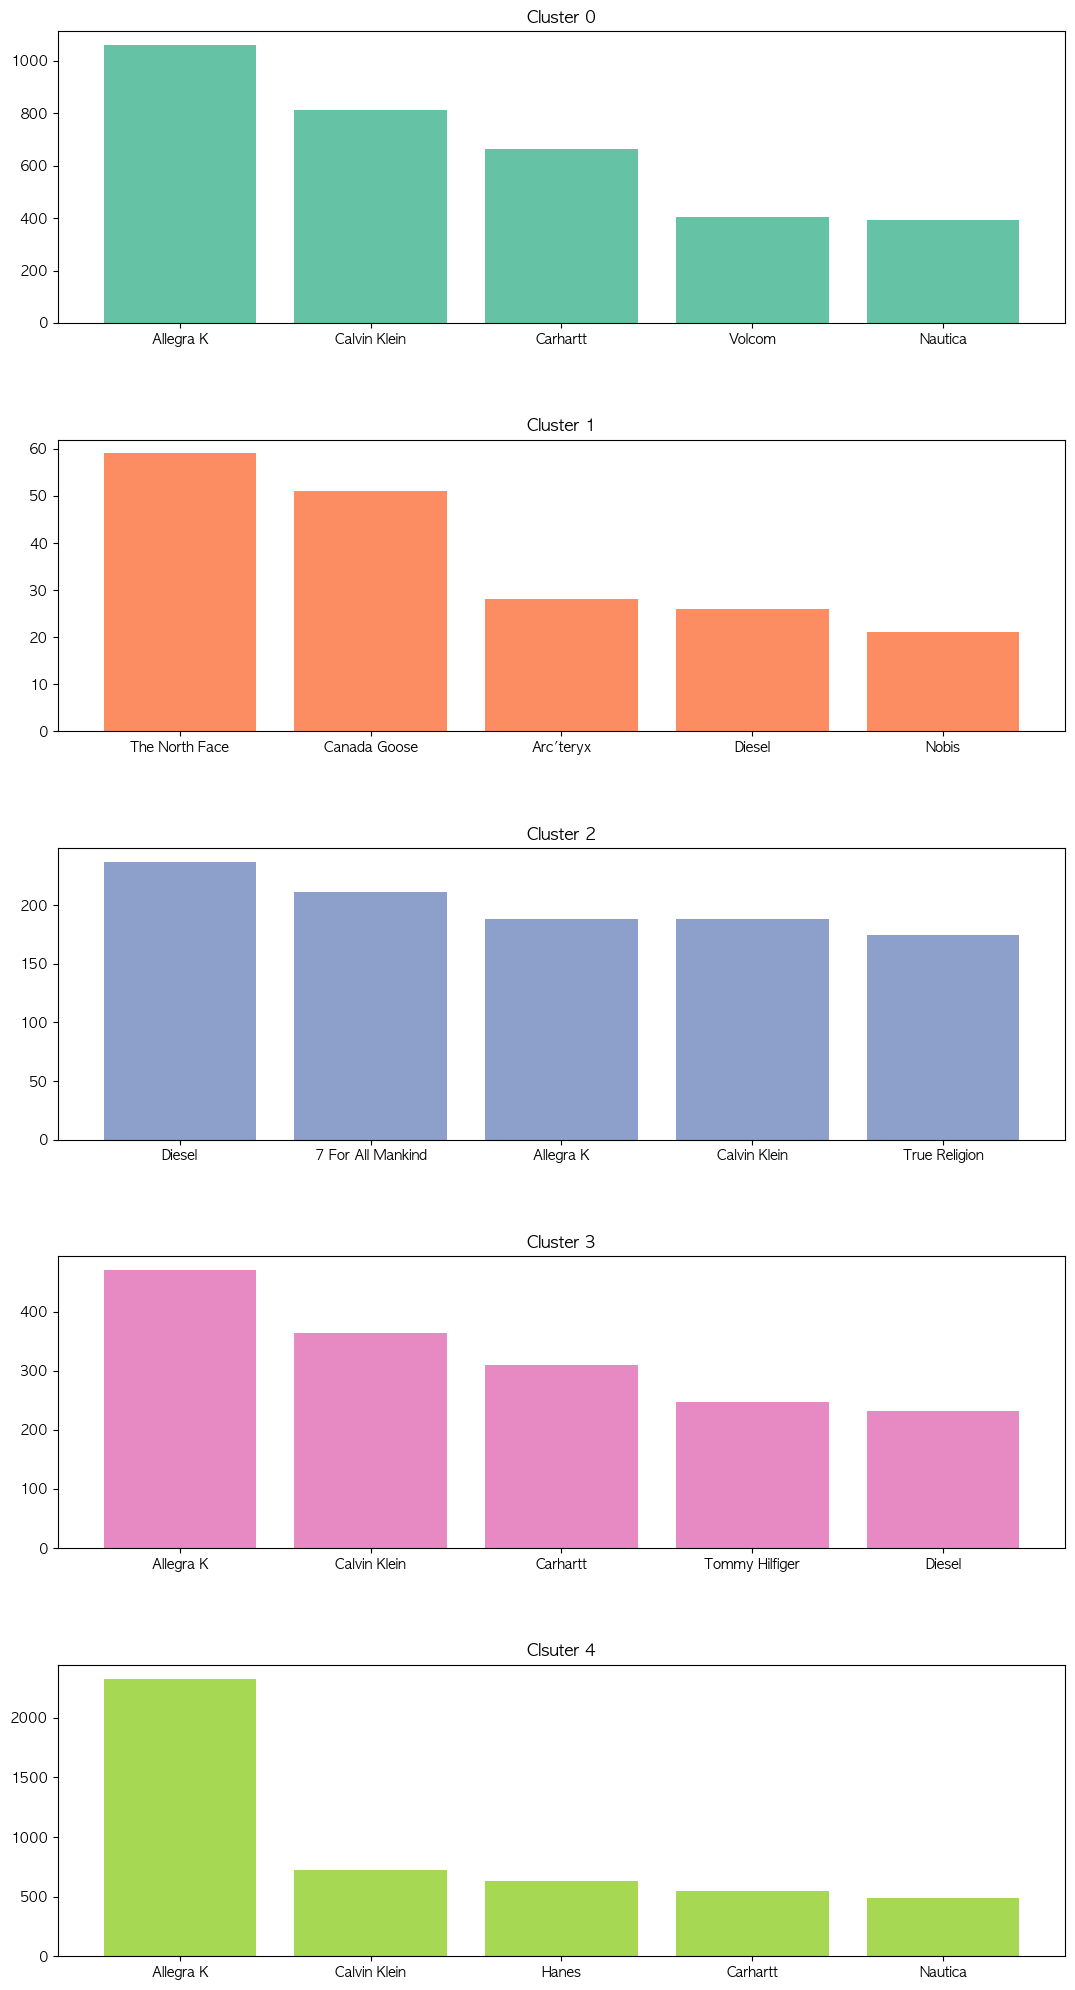

In [267]:
fig = plt.figure(figsize=(13,25))
fig.subplots_adjust(hspace=0.4)
palette = sns.color_palette("Set2", n_colors=len(clusters))

for i in range(len(clusters)):
    plt.subplot(5,1,i+1)
    data = most_purchased_brands[most_purchased_brands['cluster'] == clusters[i]]
    plt.bar(data['brand'], data['count'], color=palette[i])
    plt.title(f"{cluster_text[i]}")
plt.show()

# 고부가가치 고객 EDA

In [268]:
users = pd.read_parquet("/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/users_optimized.parquet")
users

,user_id,first_name,last_name,email,age,gender,state,street_address,postal_code,city,country,user_latitude,user_longitude,user_traffic_source,user_created_at
0,457,Timothy,Bush,timothybush@example.net,65,M,Acre,87620 Johnson Hills,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Search,2022-07-19 13:51:00+00:00
1,6578,Elizabeth,Martinez,elizabethmartinez@example.com,34,F,Acre,1705 Nielsen Land,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Search,2023-11-08 18:49:00+00:00
2,36280,Christopher,Mendoza,christophermendoza@example.net,13,M,Acre,125 Turner Isle Apt. 264,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Email,2019-08-24 06:10:00+00:00
3,60193,Jimmy,Conner,jimmyconner@example.com,64,M,Acre,0966 Jose Branch Apt. 008,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Search,2020-02-15 11:26:00+00:00
4,64231,Natasha,Wilson,natashawilson@example.net,25,F,Acre,20798 Phillip Trail Apt. 392,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Search,2020-03-13 06:45:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,93247,Crystal,Williams,crystalwilliams@example.com,36,F,Île-de-France,984 Brady Branch,77120,Beautheil-Saints,France,48.789740,3.095796,Search,2021-02-13 01:36:00+00:00
99996,59110,Daniel,Griffin,danielgriffin@example.org,12,M,Île-de-France,89560 Phillips Lakes Apt. 604,77160,Chenoise-Cucharmoy,France,48.589783,3.243343,Organic,2022-09-01 12:01:00+00:00
99997,57045,Olivia,Wiley,oliviawiley@example.org,53,F,Île-de-France,749 Ronald Forge,77320,Choisy-en-Brie,France,48.763993,3.319993,Search,2021-06-19 11:39:00+00:00
99998,73312,Emily,Bird,emilybird@example.org,16,F,Île-de-France,78117 Anderson Oval,77320,Choisy-en-Brie,France,48.763993,3.319993,Search,2023-08-08 16:24:00+00:00


Text(0.5, 1.0, '전체 고객 연령대')

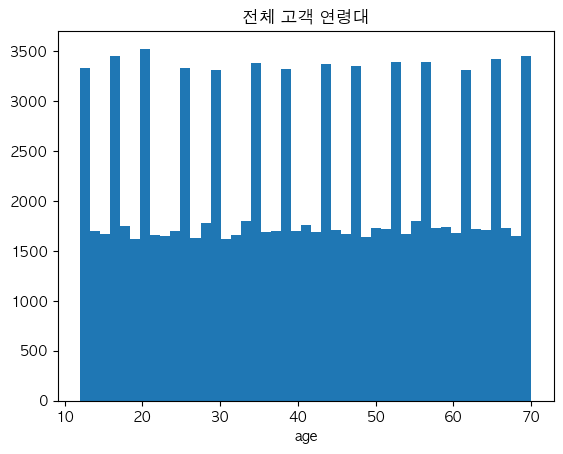

In [269]:
plt.hist(users['age'], bins=45)
plt.xlabel('age')
plt.title('전체 고객 연령대')

In [270]:
rfm_user_merged = rfm_merged.merge(users, on='user_id', how='left')
rfm_user_merged

,user_id,recency,frequency,monetary,cluster,G,K,S,M,Q,J,CLV,order_item_id,order_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,cost,category,product_name,brand,retail_price,department,sku,distribution_center_id,first_name,last_name,email,age,gender,state,street_address,postal_code,city,country,user_latitude,user_longitude,user_traffic_source,user_created_at
0,1,499,1,159.990000,0,159.990000,159.990000,0.320621,0.000000,159.990000,0.320621,480.611242,1,1,2953,3,Shipped,2022-07-20 10:32:05,2022-07-20 16:42:00+00:00,NaT,NaT,15.000000,6.000000,Active,Tommy Hilfiger Women's 3 Pack Sports Crew,Tommy Hilfiger,15.000000,Women,E2F9247929B404B2FE98BA6F32301E3B,1,Rhonda,Potter,rhondapotter@example.com,62,F,Gyeonggi-do,26092 John Well Suite 208,421-150,Bucheon City,South Korea,37.524018,126.767214,Search,2022-03-23 12:55:00+00:00
1,1,499,1,159.990000,0,159.990000,159.990000,0.320621,0.000000,159.990000,0.320621,480.611242,3,1,7656,9,Shipped,2022-07-19 11:29:28,2022-07-20 16:42:00+00:00,NaT,NaT,19.990000,8.375810,Blazers & Jackets,Plus size Button Closure Cropped Bolero Jacket...,eVogues Apparel,19.990000,Women,0DD6049F5FA537D41753BE6D37859430,5,Rhonda,Potter,rhondapotter@example.com,62,F,Gyeonggi-do,26092 John Well Suite 208,421-150,Bucheon City,South Korea,37.524018,126.767214,Search,2022-03-23 12:55:00+00:00
2,1,499,1,159.990000,0,159.990000,159.990000,0.320621,0.000000,159.990000,0.320621,480.611242,2,1,4731,7,Shipped,2022-07-20 11:05:38,2022-07-20 16:42:00+00:00,NaT,NaT,125.000000,66.750000,Jeans,Joe's Jeans Women's Skinny Jeans,Joe's Jeans,125.000000,Women,096FFC299200F51751B08DA6D865AE95,6,Rhonda,Potter,rhondapotter@example.com,62,F,Gyeonggi-do,26092 John Well Suite 208,421-150,Bucheon City,South Korea,37.524018,126.767214,Search,2022-03-23 12:55:00+00:00
3,2,649,1,22.000000,4,22.000000,22.000000,0.033898,0.000000,22.000000,0.033898,66.067797,4,2,25774,11,Complete,2022-02-20 10:28:57,2022-02-22 12:23:00+00:00,2022-02-23 18:29:00+00:00,NaT,22.000000,10.384000,Underwear,Tommy Bahama Tropical Print Boxer Short,Tommy Bahama,22.000000,Men,5F6FC587BA2A036B38AFFBB8C0A42008,4,Stephen,Burns,stephenburns@example.net,65,M,São Paulo,12512 Jonathan Divide,14404,Franca,Brasil,-20.581162,-47.386062,Organic,2020-10-19 10:34:00+00:00
4,3,115,4,100.550000,3,100.550000,402.200001,3.497391,139.391898,25.137500,0.874348,671.651138,8,6,21364,21,Complete,2023-04-03 07:50:36,2023-04-04 05:53:00+00:00,2023-04-06 03:42:00+00:00,NaT,59.500000,28.798000,Jeans,Marc Ecko Cut & Sew Men's Baked Alaska Bootcut...,Marc Ecko Cut & Sew,59.500000,Men,6B387EBBCB8020CE186644D4A4669C6A,1,Clifford,Guzman,cliffordguzman@example.org,16,M,Florida,3197 Richard Via,33009,Hallandale Beach,United States,25.985238,-80.146620,Organic,2023-03-09 09:13:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117034,99996,261,2,61.935000,0,61.935000,123.870001,0.474598,42.930071,30.967500,0.237299,260.414469,181749,125219,27368,490678,Processing,2020-08-01 23:33:20,NaT,NaT,NaT,40.000000,16.520000,Sleep & Lounge,Tommy Hilfiger Solid Black & Red Pajama Pants,Tommy Hilfiger,40.000000,Men,AF83DFE0B00BDCE9C850AE8D3C8A1B99,1,Robert,Murphy,robertmurphy@example.net,51,M,Guangdong,87464 Kathryn Islands Suite 457,522021,Nanping,China,23.514312,116.411514,Search,2019-12-30 02:00:00+00:00
117035,99998,132,3,38.996667,4,38.996667,116.990000,0.886288,42.842217,12.998889,0.295429,213.009490,181755,125223,21923,490694,Processing,2023-07-22 05:16:01,NaT,NaT,NaT,21.990000,10.027440,Pants,Allegra K Men Belt Loop Pleats Slant Pockets C...,Allegra K,21.990000,Men,6D7C8FCB2F7A9E4126A6BE9777C5CA49,9,David,Tran,davidtran@example.org,51,M,North Carolina,3759 Mullins Well Suite 754,28715,Candler,United States,35.512934,-82.716829,Search,2022-10-31 07:27:00+00:00
117036,99998,132,3,38.996667,4,38.996667,116.990000,0.886288,42.842217

In [271]:
high_clv_user = rfm_user_merged[(rfm_user_merged['cluster']==3) | (rfm_user_merged['cluster']==4)]
high_clv_user

,user_id,recency,frequency,monetary,cluster,G,K,S,M,Q,J,CLV,order_item_id,order_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,cost,category,product_name,brand,retail_price,department,sku,distribution_center_id,first_name,last_name,email,age,gender,state,street_address,postal_code,city,country,user_latitude,user_longitude,user_traffic_source,user_created_at
3,2,649,1,22.000000,4,22.000000,22.000000,0.033898,0.000000,22.000000,0.033898,66.067797,4,2,25774,11,Complete,2022-02-20 10:28:57,2022-02-22 12:23:00+00:00,2022-02-23 18:29:00+00:00,NaT,22.000000,10.384000,Underwear,Tommy Bahama Tropical Print Boxer Short,Tommy Bahama,22.000000,Men,5F6FC587BA2A036B38AFFBB8C0A42008,4,Stephen,Burns,stephenburns@example.net,65,M,São Paulo,12512 Jonathan Divide,14404,Franca,Brasil,-20.581162,-47.386062,Organic,2020-10-19 10:34:00+00:00
4,3,115,4,100.550000,3,100.550000,402.200001,3.497391,139.391898,25.137500,0.874348,671.651138,8,6,21364,21,Complete,2023-04-03 07:50:36,2023-04-04 05:53:00+00:00,2023-04-06 03:42:00+00:00,NaT,59.500000,28.798000,Jeans,Marc Ecko Cut & Sew Men's Baked Alaska Bootcut...,Marc Ecko Cut & Sew,59.500000,Men,6B387EBBCB8020CE186644D4A4669C6A,1,Clifford,Guzman,cliffordguzman@example.org,16,M,Florida,3197 Richard Via,33009,Hallandale Beach,United States,25.985238,-80.146620,Organic,2023-03-09 09:13:00+00:00
5,3,115,4,100.550000,3,100.550000,402.200001,3.497391,139.391898,25.137500,0.874348,671.651138,5,3,22308,13,Processing,2023-04-23 09:04:57,NaT,NaT,NaT,59.990002,30.174971,Pants,Dockers Men's Limited Offer D2 Stretch Khaki Pant,Dockers,59.990002,Men,4B6E16D36F691EEC61154D01871CEC76,7,Clifford,Guzman,cliffordguzman@example.org,16,M,Florida,3197 Richard Via,33009,Hallandale Beach,United States,25.985238,-80.146620,Organic,2023-03-09 09:13:00+00:00
6,3,115,4,100.550000,3,100.550000,402.200001,3.497391,139.391898,25.137500,0.874348,671.651138,9,6,28050,23,Complete,2023-04-05 07:41:13,2023-04-04 05:53:00+00:00,2023-04-06 03:42:00+00:00,NaT,63.970001,40.748891,Swim,Volcom Men's Bruce Annihilator Board-Shorts,Volcom,63.970001,Men,A4D35E93D6C0787428F2FDF6A29457E0,4,Clifford,Guzman,cliffordguzman@example.org,16,M,Florida,3197 Richard Via,33009,Hallandale Beach,United States,25.985238,-80.146620,Organic,2023-03-09 09:13:00+00:00
7,3,115,4,100.550000,3,100.550000,402.200001,3.497391,139.391898,25.137500,0.874348,671.651138,6,4,26696,15,Processing,2023-08-08 06:13:20,NaT,NaT,NaT,108.750000,47.306250,Sleep & Lounge,Tommy Bahama Terry Loop Robe,Tommy Bahama,108.750000,Men,A03175E68893309A3C69D0B9E018BCCA,4,Clifford,Guzman,cliffordguzman@example.org,16,M,Florida,3197 Richard Via,33009,Hallandale Beach,United States,25.985238,-80.146620,Organic,2023-03-09 09:13:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117029,99992,479,1,55.950001,4,55.950001,55.950001,0.116806,0.000000,55.950001,0.116806,168.083614,181745,125217,7101,490668,Shipped,2022-08-08 14:24:09,2022-08-08 02:54:00+00:00,NaT,NaT,19.950001,7.999950,Skirts,Black Shiny Liquid Mini Skirt Elastic Waist Band,FineBrandShop,19.950001,Women,B33128CB0089003DDFB5199E1B679652,7,Lindsay,Mendez,lindsaymendez@example.org,33,F,Michigan,3203 Brandon Shore,48035,Clinton Township,United States,42.556171,-82.909536,Search,2021-12-14 14:25:00+00:00
117030,99992,479,1,55.950001,4,55.950001,55.950001,0.116806,0.000000,55.950001,0.116806,168.083614,181747,125217,11362,490672,Shipped,2022-08-09 12:30:51,2022-08-08 02:54:00+00:00,NaT,NaT,24.000000,12.336000,Intimates,Slim Me By Me Moi Shaping Cami,Slim Me,24.000000,Women,0DE109FEF33CF60A1961608C8BEFD161,1,Lindsay,Mendez,lindsaymendez@example.org,33,F,Michigan,3203 Brandon Shore,48035,Clinton Township,United States,42.556171,-82.909536,Search,2021-12-14 14:25:00+00:00
117035,99998,132,3,38.996667,4,38.996667,116.990000,0.886288,42.842217,12.998889,0.295429,213.0

Text(0.5, 1.0, '고부가가치 고객(cluster 3,4) 연령대')

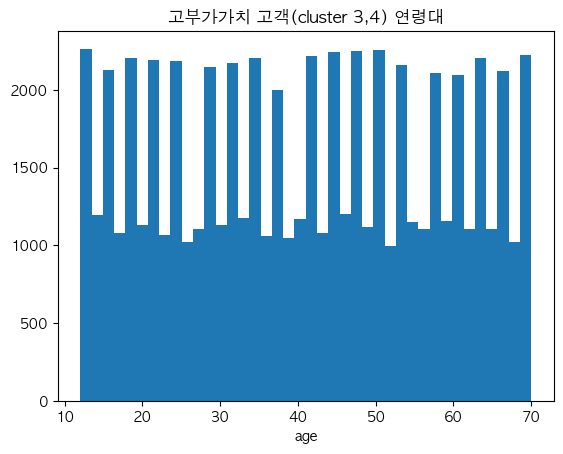

In [272]:
plt.hist(high_clv_user['age'],bins=40)
plt.xlabel('age')
plt.title('고부가가치 고객(cluster 3,4) 연령대')

In [273]:
high_clv_user.describe()

,user_id,recency,frequency,monetary,cluster,G,K,S,M,Q,J,CLV,order_item_id,order_id,product_id,inventory_item_id,created_at,sale_price,cost,retail_price,distribution_center_id,age,user_latitude,user_longitude
count,64575.0,64575.000000,64575.000000,64575.000000,64575.000000,64575.000000,64575.000000,64575.000000,64575.000000,64575.000000,64575.000000,64575.000000,64575.0,64575.0,64575.0,64575.0,64575,64575.000000,64575.000000,64575.000000,64575.0,64575.0,64575.000000,64575.000000
mean,50333.184886,371.663864,1.786171,73.270820,3.706961,73.270820,155.647878,3.899961,47.893521,42.365213,1.652726,324.730120,91517.502439,63018.944003,15276.832226,247012.926039,2022-08-12 14:19:21.353573120,47.741705,23.093253,47.741705,5.018335,40.925962,28.450450,24.603602
min,2.0,1.000000,1.000000,0.020000,3.000000,0.020000,0.020000,0.000076,0.000000,0.020000,0.000076,0.060153,4.0,2.0,1.0,11.0,2019-01-11 16:29:00,0.020000,0.008300,0.020000,1.0,12.0,-42.964120,-158.164931
25%,25584.5,96.000000,1.000000,30.950001,3.000000,30.950001,38.500000,0.096955,0.000000,20.649688,0.078885,107.529666,46445.5,31964.5,8060.5,125276.0,2021-12-09 20:21:07,20.000000,9.942500,20.000000,2.0,26.0,26.269040,-51.502627
50%,50738.0,258.000000,2.000000,49.990002,4.000000,49.990002,69.490000,0.357463,13.509438,34.000000,0.223507,180.677966,92255.0,63474.0,15684.0,249002.0,2022-11-25 00:19:40,34.000000,16.560000,34.000000,5.0,41.0,35.215685,4.921592
75%,75021.5,548.000000,2.000000,95.892501,4.000000,95.892501,289.060001,1.521845,102.027800,59.990002,0.746500,563.191182,136623.5,94055.5,22760.5,368796.0,2023-07-07 02:52:56.500000,54.990002,27.084149,54.990002,8.0,56.0,40.707515,116.376103
max,99998.0,1783.000000,4.000000,372.495001,4.000000,372.495001,1009.890003,930.430000,350.001204,186.247500,310.143333,2925.255056,181755.0,125223.0,29120.0,490694.0,2023-11-30 23:58:54,903.000000,512.001000,903.000000,10.0,70.0,64.865194,153.560238
std,28771.750775,353.323388,0.921816,61.960475,0.455160,61.960475,173.848234,22.858903,66.203198,28.762693,8.533551,321.889807,52362.296593,36052.386025,8430.130034,141372.870757,NaN,52.028418,24.088609,52.028418,2.910908,17.034316,21.818944,90.248265


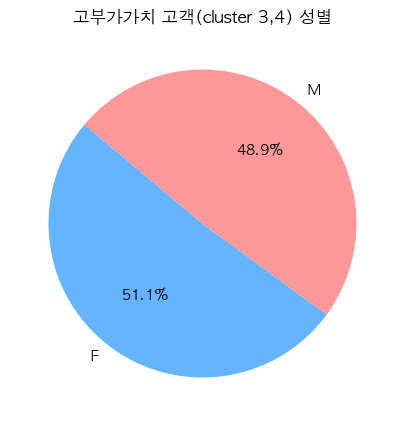

In [274]:
gender_counts = high_clv_user['gender'].value_counts()

# 시각화
labels = high_clv_user['gender']
sizes = high_clv_user['user_id'].count()

colors = ['#66b3ff','#ff9999']

# 파이 차트 생성
plt.figure(figsize=(5, 5))
plt.pie(gender_counts, labels=gender_counts.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('고부가가치 고객(cluster 3,4) 성별')
plt.show()

In [275]:
rfm_merged[rfm_merged['user_id']==17].sort_values('created_at')

,user_id,recency,frequency,monetary,cluster,G,K,S,M,Q,J,CLV,order_item_id,order_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,cost,category,product_name,brand,retail_price,department,sku,distribution_center_id
25,17,1126,3,249.329995,3,249.329995,747.989986,0.66429,273.916997,83.109998,0.22143,1355.232697,37,24,24171,103,Complete,2019-06-17 08:42:54,2019-06-15 13:55:00+00:00,2019-06-16 12:28:00+00:00,NaT,119.989998,49.195899,Outerwear & Coats,Tommy Hilfiger Men's Melton Walking Coat,Tommy Hilfiger,119.989998,Men,418BF1CE1437ADEEB5D0352FCD92B1D2,1
22,17,1126,3,249.329995,3,249.329995,747.989986,0.66429,273.916997,83.109998,0.22143,1355.232697,38,24,28283,105,Complete,2019-06-18 11:18:10,2019-06-15 13:55:00+00:00,2019-06-16 12:28:00+00:00,NaT,53.970001,33.515371,Swim,Quiksilver Men's Cypher Alpha 21 Kelly Slater ...,Quiksilver,53.970001,Men,C08876CB72B043BFBD2009CB2F0ECBF5,9
21,17,1126,3,249.329995,3,249.329995,747.989986,0.66429,273.916997,83.109998,0.22143,1355.232697,43,26,16381,120,Shipped,2020-09-18 10:15:08,2020-09-20 20:20:00+00:00,NaT,NaT,21.450001,13.041600,Tops & Tees,Â Â Exclusive Hawaiian Sunset In Paradise Aloh...,WinnieFashion,21.450001,Men,25D36360C95DDCDD9687DD95F09AB64C,10
24,17,1126,3,249.329995,3,249.329995,747.989986,0.66429,273.916997,83.109998,0.22143,1355.232697,39,25,23584,108,Complete,2020-10-29 08:44:10,2020-10-31 14:57:00+00:00,2020-11-03 02:50:00+00:00,NaT,74.250000,34.971750,Shorts,Ben Sherman Men's Lightly Washed Oxford Shorts,Ben Sherman,74.250000,Men,27554B4E74F998F4D3BA09D6AD8A7298,4
23,17,1126,3,249.329995,3,249.329995,747.989986,0.66429,273.916997,83.109998,0.22143,1355.232697,41,25,29058,114,Complete,2020-10-29 12:27:02,2020-10-31 14:57:00+00:00,2020-11-03 02:50:00+00:00,NaT,65.000000,26.000000,Accessories,Oakley Flak Jacket Standard Replacement Lens R...,Oakley,65.000000,Men,50C0825021514D9E67849B768C681EC1,8
27,17,1126,3,249.329995,3,249.329995,747.989986,0.66429,273.916997,83.109998,0.22143,1355.232697,40,25,18612,112,Complete,2020-10-31 08:42:05,2020-10-31 14:57:00+00:00,2020-11-03 02:50:00+00:00,NaT,293.329987,135.811785,Active,Champion Men's Double Dry Classic Fleece Full ...,Champion,293.329987,Men,A50303D16C89E22C53D45BD5B9FD888B,2
26,17,1126,3,249.329995,3,249.329995,747.989986,0.66429,273.916997,83.109998,0.22143,1355.232697,42,25,23645,116,Complete,2020-10-31 09:06:04,2020-10-31 14:57:00+00:00,2020-11-03 02:50:00+00:00,NaT,120.000000,58.320000,Outerwear & Coats,Carhartt Men's Sandstone Active Jacket - Quilt...,Carhartt,120.000000,Men,A0164CBFE882AA11E433A6B503CB62DB,3


In [276]:
# 클러스터 3에 해당하는 데이터 추출
cluster_3_data = rfm_user_merged[rfm_user_merged['cluster'] == 3]

# 구매 주기 분석
purchase_frequency = cluster_3_data['recency'].mean()  # 평균 구매 주기

# 구매 빈도 분석
purchase_count = cluster_3_data.shape[0]  # 구매 횟수

# 평균 구매금액 분석
average_purchase_amount = cluster_3_data['monetary'].mean()  # 평균 구매금액

# 결과 출력
print("구매 주기 (평균): {:.2f} 일".format(purchase_frequency))
print("구매 빈도: {}".format(purchase_count))
print("평균 구매금액: {:.2f}".format(average_purchase_amount))


구매 주기 (평균): 275.00 일
구매 빈도: 18923
평균 구매금액: 153.60


In [277]:
rfm_user_merged.groupby('cluster').agg({
    'recency' : ['mean', 'min', 'max'],  ## 구매 주기
    'frequency' : ['mean', 'min', 'max'],  ## 구매 빈도 
    'monetary' : ['mean', 'min', 'max'],  ## 한번 주문시 평균 금액
    'K' : ['mean', 'min', 'max', 'sum'], ##  총 구매금액 
    'CLV' : ['mean', 'min', 'max', 'count']
})

recency           frequency            monetary              \
               mean min   max      mean min max        mean         min   
cluster                                                                   
0        366.934223   1  1789  1.801124   1   4  100.251007   35.422501   
1        403.139231   1  1734  1.515591   1   4  577.471840  269.847500   
2        452.772556   1  1769  1.000000   1   1  263.473317  183.290001   
3        274.996618   1  1582  2.776568   2   4  153.598094   67.730000   
4        411.732958   1  1783  1.375646   1   4   39.974733    0.020000   

                               K                                         \
                 max        mean         min          max           sum   
cluster                                                                   
0         183.129999  160.689616   82.000000   270.359998  6.547138e+06   
1        1341.489998  790.820297  462.490005  1405.619991  1.090541e+06   
2         461.140000  263.473317  183.290001   461.140000  2.724578e+06   
3         372.495001  401.345161  262.269993  1009.890003  7.594654e+06   
4          82.389999   53.805031    0.020000   140.770002  2.456307e+06   

                 CLV                                   
                mean          min          max  count  
cluster                                                
0         378.882510   235.321851   892.199993  40744  
1        2006.539980  1388.126963  4101.126565   1379  
2         797.493380   551.221050  2179.749947  10341  
3         774.551852   453.443694  2925.255056  18923  
4         138.276588     0.060153   412.491034  45652

## 구매가 활발한 시간대

In [278]:
rfm_user_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117039 entries, 0 to 117038
Data columns (total 44 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   user_id                 117039 non-null  Int32              
 1   recency                 117039 non-null  int64              
 2   frequency               117039 non-null  int64              
 3   monetary                117039 non-null  float64            
 4   cluster                 117039 non-null  int32              
 5   G                       117039 non-null  float64            
 6   K                       117039 non-null  float64            
 7   S                       117039 non-null  float64            
 8   M                       117039 non-null  float64            
 9   Q                       117039 non-null  float64            
 10  J                       117039 non-null  float64            
 11  CLV                     11

In [279]:
rfm_user_merged['order_hour'] = rfm_user_merged['created_at'].dt.hour

hourly_purchase_counts = rfm_user_merged['order_hour'].value_counts().sort_index()
hourly_purchase_counts

order_hour
0     6126
1     6138
2     5920
3     6059
4     5916
5     6105
6     6171
7     6354
8     6205
9     6224
10    6315
11    6307
12    6191
13    6173
14    5980
15    5705
16    3994
17    2530
18    1039
19      17
20     561
21    2069
22    3727
23    5213
Name: count, dtype: int64

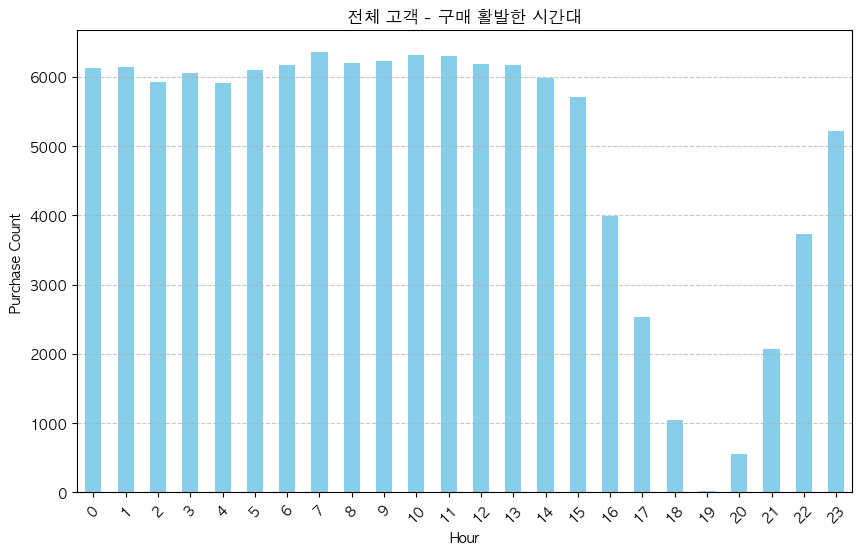

In [280]:
plt.figure(figsize=(10, 6))
hourly_purchase_counts.plot(kind='bar', color='skyblue')
plt.title('전체 고객 - 구매 활발한 시간대')
plt.xlabel('Hour')
plt.ylabel('Purchase Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [281]:
rfm_user_merged['order_dayofweek'] = rfm_user_merged['created_at'].dt.dayofweek

day_of_week_labels = {0: 'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}

dow_purchase_counts = rfm_user_merged['order_dayofweek'].map(day_of_week_labels).value_counts().reindex(day_of_week_labels.values())
dow_purchase_counts

order_dayofweek
Mon    16734
Tue    16764
Wed    16814
Thu    16850
Fri    16364
Sat    16672
Sun    16841
Name: count, dtype: int64

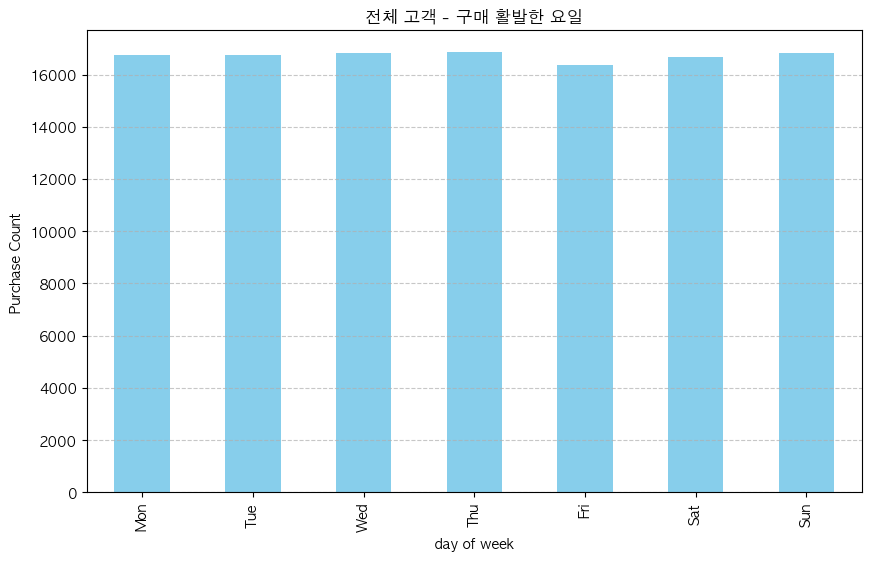

In [282]:
plt.figure(figsize=(10, 6))
dow_purchase_counts.plot(kind='bar', color='skyblue')
plt.title('전체 고객 - 구매 활발한 요일')
plt.xlabel('day of week')
plt.ylabel('Purchase Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [283]:
cluster_1 = rfm_user_merged[rfm_user_merged['cluster']==1]
cluster_1

,user_id,recency,frequency,monetary,cluster,G,K,S,M,Q,J,CLV,order_item_id,order_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,cost,category,product_name,brand,retail_price,department,sku,distribution_center_id,first_name,last_name,email,age,gender,state,street_address,postal_code,city,country,user_latitude,user_longitude,user_traffic_source,user_created_at,order_hour,order_dayofweek
588,516,1,1,483.990002,1,483.990002,483.990002,483.990002,0.000000,483.990002,483.990002,2419.950008,945,643,20561,2602,Shipped,2023-11-30 12:54:42,2023-11-29 10:27:00+00:00,NaT,NaT,54.990002,29.584621,Jeans,Levi's Men's 501 Shrink To Fit Jean,Levi's,54.990002,Men,65D1B8A382FE0421B1C1D5B932BAF87A,4,Nicholas,Brown,nicholasbrown@example.net,28,M,Busan,0682 Benjamin Extensions Suite 689,604-040,Busan,South Korea,35.075052,128.958004,Search,2023-08-24 14:59:00+00:00,12,3
589,516,1,1,483.990002,1,483.990002,483.990002,483.990002,0.000000,483.990002,483.990002,2419.950008,944,643,24177,2600,Shipped,2023-11-30 11:59:03,2023-11-29 10:27:00+00:00,NaT,NaT,429.000000,204.204000,Outerwear & Coats,Marc New York by Andrew Marc Men's Liam Smooth...,Marc New York by Andrew Marc,429.000000,Men,2E99E68E7C01590F28BF0B64E645F856,8,Nicholas,Brown,nicholasbrown@example.net,28,M,Busan,0682 Benjamin Extensions Suite 689,604-040,Busan,South Korea,35.075052,128.958004,Search,2023-08-24 14:59:00+00:00,11,3
682,596,1225,1,489.299995,1,489.299995,489.299995,0.399429,0.000000,489.299995,0.399429,1468.698843,1096,745,28372,2999,Processing,2020-07-23 14:18:26,NaT,NaT,NaT,51.750000,23.132250,Accessories,Williams Cashmere Men's 100% Cashmere Solid Kn...,Williams Cashmere,51.750000,Men,DD2CC2088B77D344F7B5EC13E6FF4922,2,Russell,Scott,russellscott@example.com,42,M,Maranhão,4717 Wolfe Vista Apt. 144,65360-000,Outeiro,Brasil,-3.460563,-45.332942,Organic,2019-08-06 15:06:00+00:00,14,3
683,596,1225,1,489.299995,1,489.299995,489.299995,0.399429,0.000000,489.299995,0.399429,1468.698843,1094,745,26828,2995,Processing,2020-07-20 13:23:09,NaT,NaT,NaT,124.599998,44.482199,Sleep & Lounge,Pendleton Men's Chief Joseph Terry Velore Bath...,Pendleton,124.599998,Men,A8AECE0882371F438C829BCCB995A927,9,Russell,Scott,russellscott@example.com,42,M,Maranhão,4717 Wolfe Vista Apt. 144,65360-000,Outeiro,Brasil,-3.460563,-45.332942,Organic,2019-08-06 15:06:00+00:00,13,0
684,596,1225,1,489.299995,1,489.299995,489.299995,0.399429,0.000000,489.299995,0.399429,1468.698843,1093,745,24216,2993,Processing,2020-07-20 14:33:17,NaT,NaT,NaT,139.000000,63.384000,Outerwear & Coats,Sons of Anarchy Men's Highway Denim Jacket,Sons of Anarchy,139.000000,Men,EC23187ECC4E0C6EB40CD187DB4A865C,3,Russell,Scott,russellscott@example.com,42,M,Maranhão,4717 Wolfe Vista Apt. 144,65360-000,Outeiro,Brasil,-3.460563,-45.332942,Organic,2019-08-06 15:06:00+00:00,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116079,99146,48,2,501.245001,1,501.245001,1002.490002,20.885208,347.436559,250.622500,10.442604,2133.121875,180213,124142,17094,486567,Processing,2023-09-25 22:47:44,NaT,NaT,NaT,903.000000,524.643000,Fashion Hoodies & Sweatshirts,The North Face Apex Bionic Soft Shell Jacket -...,The North Face,903.000000,Men,08ED87BD895F5562AACFFD47D4C086EB,3,Benjamin,Welch,benjaminwelch@example.net,38,M,Guangdong,5551 Short Turnpike Apt. 503,528313,Tianjin,China,22.955017,113.231504,Search,2023-05-29 02:22:00+00:00,22,0
116279,99322,606,1,792.000000,1,792.000000,792.000000,1.306931,0.000000,792.000000,1.306931,2378.613861,180531,124358,20150,487428,Shipped,2022-04-03 03:56:34,2022-04-04 02:30:00+00:00,NaT,NaT,297.000000,131.571000,Suits & Sport Coats,Joseph Abboud Men's 2 Button Side Vent Soft Co...,Joseph Abboud,297.000000,Men,DFC0DDF31F87EEEF737FFB16705467B5,5,Mathew,Huerta,mathewhuerta@example.org,31,M,Provence-Alpes-Côte d'Azur,518 Miles Skyway,83260,La 

In [284]:
rfm_user_merged[rfm_user_merged['user_id']==596]

,user_id,recency,frequency,monetary,cluster,G,K,S,M,Q,J,CLV,order_item_id,order_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,cost,category,product_name,brand,retail_price,department,sku,distribution_center_id,first_name,last_name,email,age,gender,state,street_address,postal_code,city,country,user_latitude,user_longitude,user_traffic_source,user_created_at,order_hour,order_dayofweek
682,596,1225,1,489.299995,1,489.299995,489.299995,0.399429,0.0,489.299995,0.399429,1468.698843,1096,745,28372,2999,Processing,2020-07-23 14:18:26,NaT,NaT,NaT,51.750000,23.132250,Accessories,Williams Cashmere Men's 100% Cashmere Solid Kn...,Williams Cashmere,51.750000,Men,DD2CC2088B77D344F7B5EC13E6FF4922,2,Russell,Scott,russellscott@example.com,42,M,Maranhão,4717 Wolfe Vista Apt. 144,65360-000,Outeiro,Brasil,-3.460563,-45.332942,Organic,2019-08-06 15:06:00+00:00,14,3
683,596,1225,1,489.299995,1,489.299995,489.299995,0.399429,0.0,489.299995,0.399429,1468.698843,1094,745,26828,2995,Processing,2020-07-20 13:23:09,NaT,NaT,NaT,124.599998,44.482199,Sleep & Lounge,Pendleton Men's Chief Joseph Terry Velore Bath...,Pendleton,124.599998,Men,A8AECE0882371F438C829BCCB995A927,9,Russell,Scott,russellscott@example.com,42,M,Maranhão,4717 Wolfe Vista Apt. 144,65360-000,Outeiro,Brasil,-3.460563,-45.332942,Organic,2019-08-06 15:06:00+00:00,13,0
684,596,1225,1,489.299995,1,489.299995,489.299995,0.399429,0.0,489.299995,0.399429,1468.698843,1093,745,24216,2993,Processing,2020-07-20 14:33:17,NaT,NaT,NaT,139.000000,63.384000,Outerwear & Coats,Sons of Anarchy Men's Highway Denim Jacket,Sons of Anarchy,139.000000,Men,EC23187ECC4E0C6EB40CD187DB4A865C,3,Russell,Scott,russellscott@example.com,42,M,Maranhão,4717 Wolfe Vista Apt. 144,65360-000,Outeiro,Brasil,-3.460563,-45.332942,Organic,2019-08-06 15:06:00+00:00,14,0
685,596,1225,1,489.299995,1,489.299995,489.299995,0.399429,0.0,489.299995,0.399429,1468.698843,1095,745,20733,2997,Processing,2020-07-24 14:52:04,NaT,NaT,NaT,173.949997,84.365748,Jeans,Diesel Men's Larkee Regular Straight Leg 801Z ...,Diesel,173.949997,Men,67EB5E92661B494826ADD1D403863257,10,Russell,Scott,russellscott@example.com,42,M,Maranhão,4717 Wolfe Vista Apt. 144,65360-000,Outeiro,Brasil,-3.460563,-45.332942,Organic,2019-08-06 15:06:00+00:00,14,4
